In [5]:
import os
import re
import random
import time
import numpy as np
import torch
import math
import glob
from time import perf_counter

from erfnet import ErfNet
from unet import UNet
from deeplab.deeplab import DeepLab
from resnet_oc.resnet_oc import get_resnet34_base_oc_layer3

from mapillary import mapillary
from torch.utils.data import DataLoader
from argparse import ArgumentParser
from transform import Colorize
from torchvision.transforms import ToTensor, ToPILImage

from iouEval import iouEval
import wandb

import numpy as np
import os
import random

from torchvision.transforms import Compose, CenterCrop, Normalize, Resize, Pad
from torchvision.transforms import ToTensor, ToPILImage
from transform import Relabel, ToLabel, Colorize

from PIL import Image, ImageOps

from torch.utils.data import Dataset

NUM_CLASSES = 66

MODELS = {
    'erfnet':ErfNet(NUM_CLASSES),
    'unet':UNet(3,NUM_CLASSES),
    'deeplab':DeepLab(backbone='mobilenet', output_stride=16, num_classes=NUM_CLASSES, sync_bn=False, freeze_bn=False),
    'resnet_oc':get_resnet34_base_oc_layer3(),
}

In [60]:
model = MODELS['resnet_oc']
model = torch.nn.DataParallel(model).cuda()
model.eval()
model.load_state_dict(torch.load('./save/resnet_oc/model-24.pth')['model'])

<All keys matched successfully>

In [61]:
image_path = '/media/alexey/HDD/Mapillary/val/1920_1080/images/-3-MmXdwhyIQhtb4-8NqHQ.jpg'
mask_path = '/media/alexey/HDD/Mapillary/val/1920_1080/labels/-3-MmXdwhyIQhtb4-8NqHQ.png'

with open(image_path, 'rb') as f:
    image = Image.open(f).convert('RGB')
with open(mask_path, 'rb') as f:
    label = Image.open(f).convert('P')

image = ToTensor()(image)

label = ToLabel()(label)
label = Relabel(255, 65)(label)

In [62]:
with torch.no_grad():
    image = image[None,:,:,:]
    image = image.cuda()
    output = model(image)

In [63]:
from transform import Colorize
color_transform = Colorize(NUM_CLASSES)

In [64]:
res = Image.fromarray(np.moveaxis(np.array(color_transform(output[0].cpu().max(0)[1].data.unsqueeze(0))),0,2))

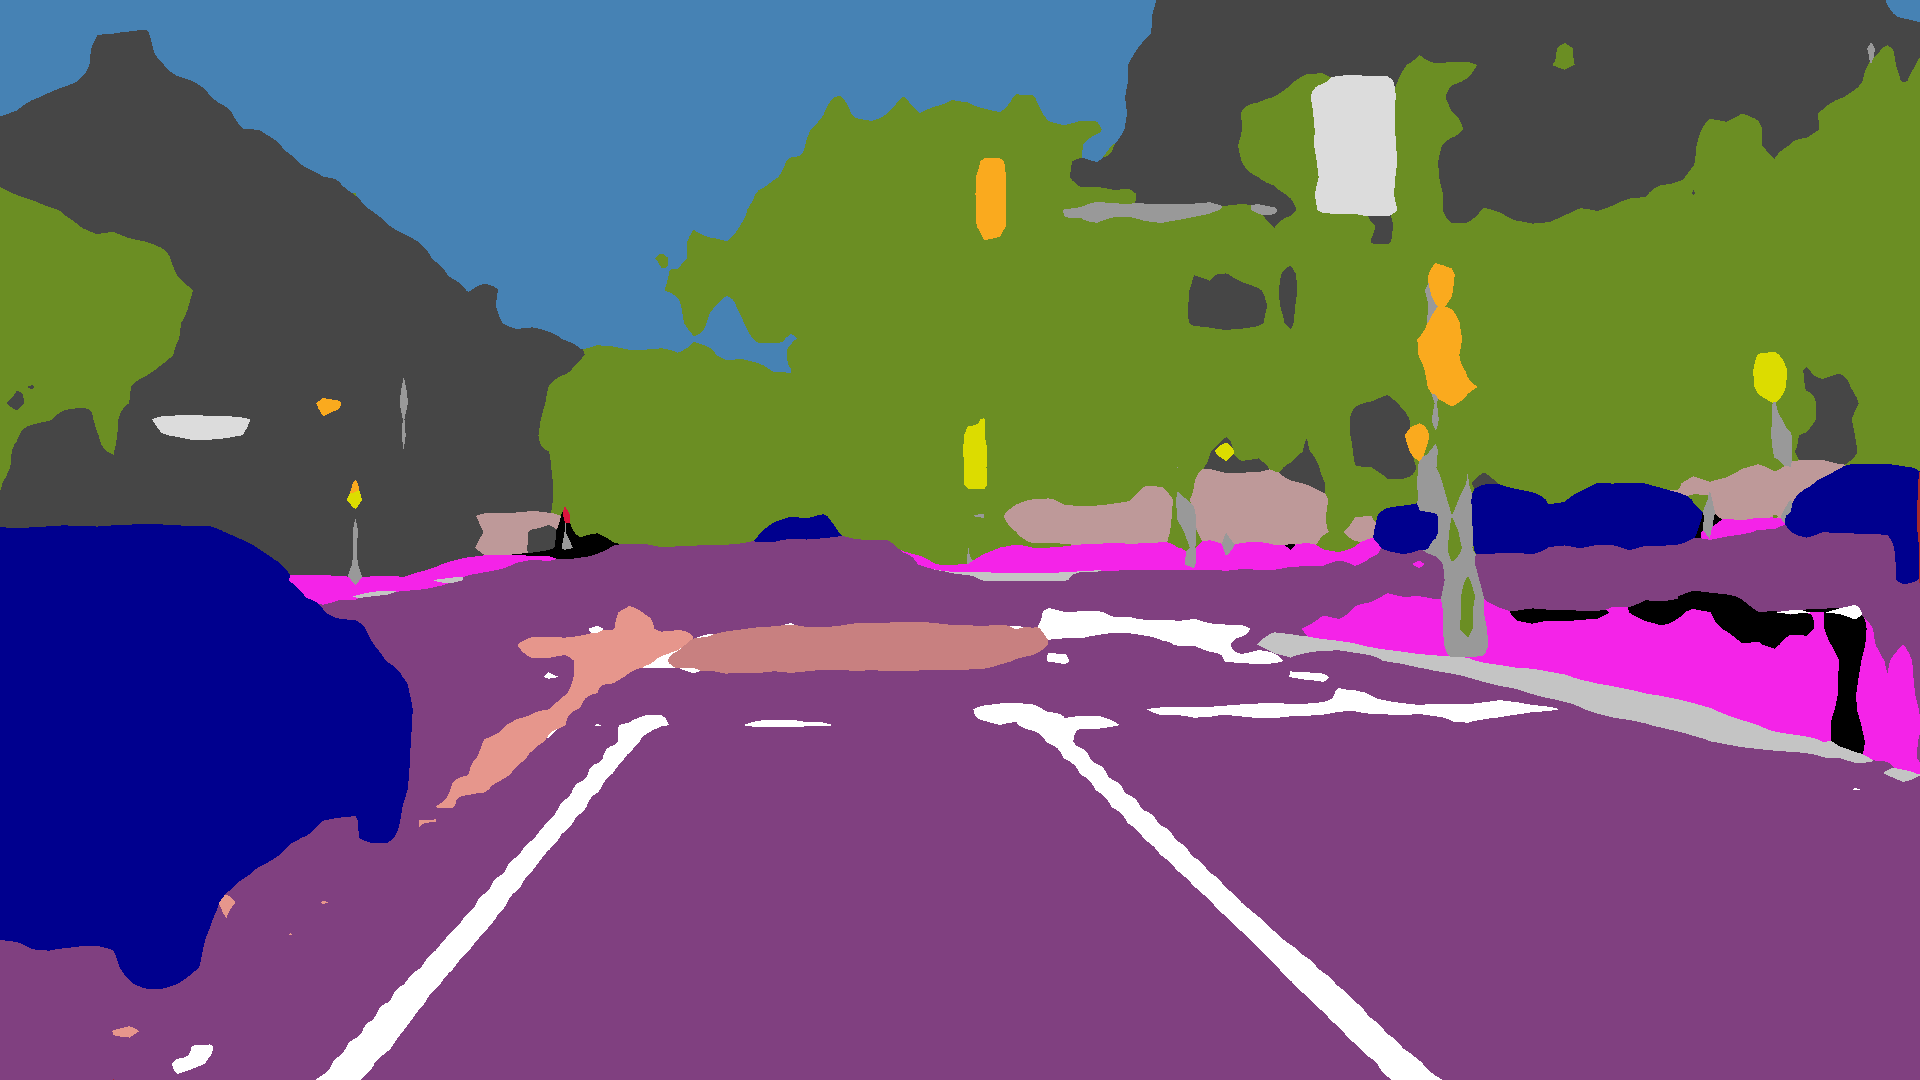

In [65]:
res

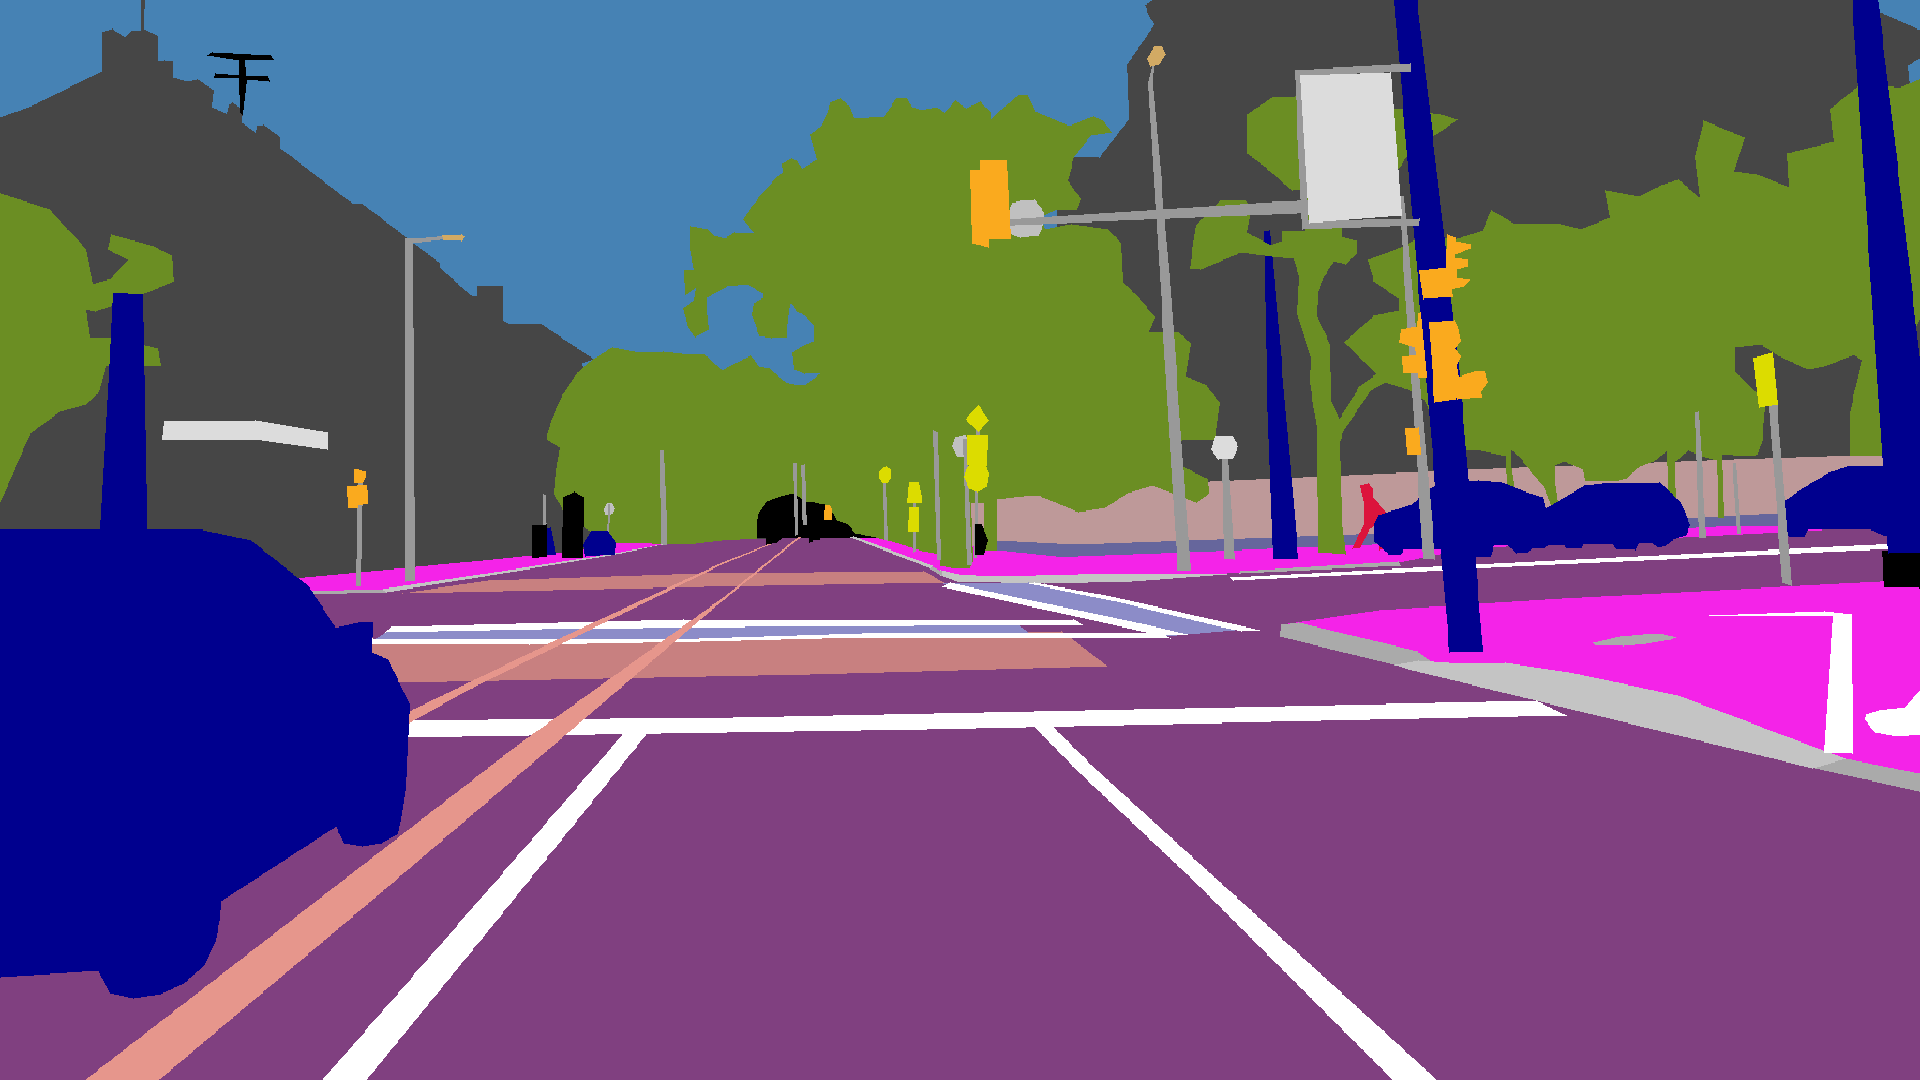

In [66]:
Image.fromarray(np.moveaxis(np.array(color_transform(label)),0,2))

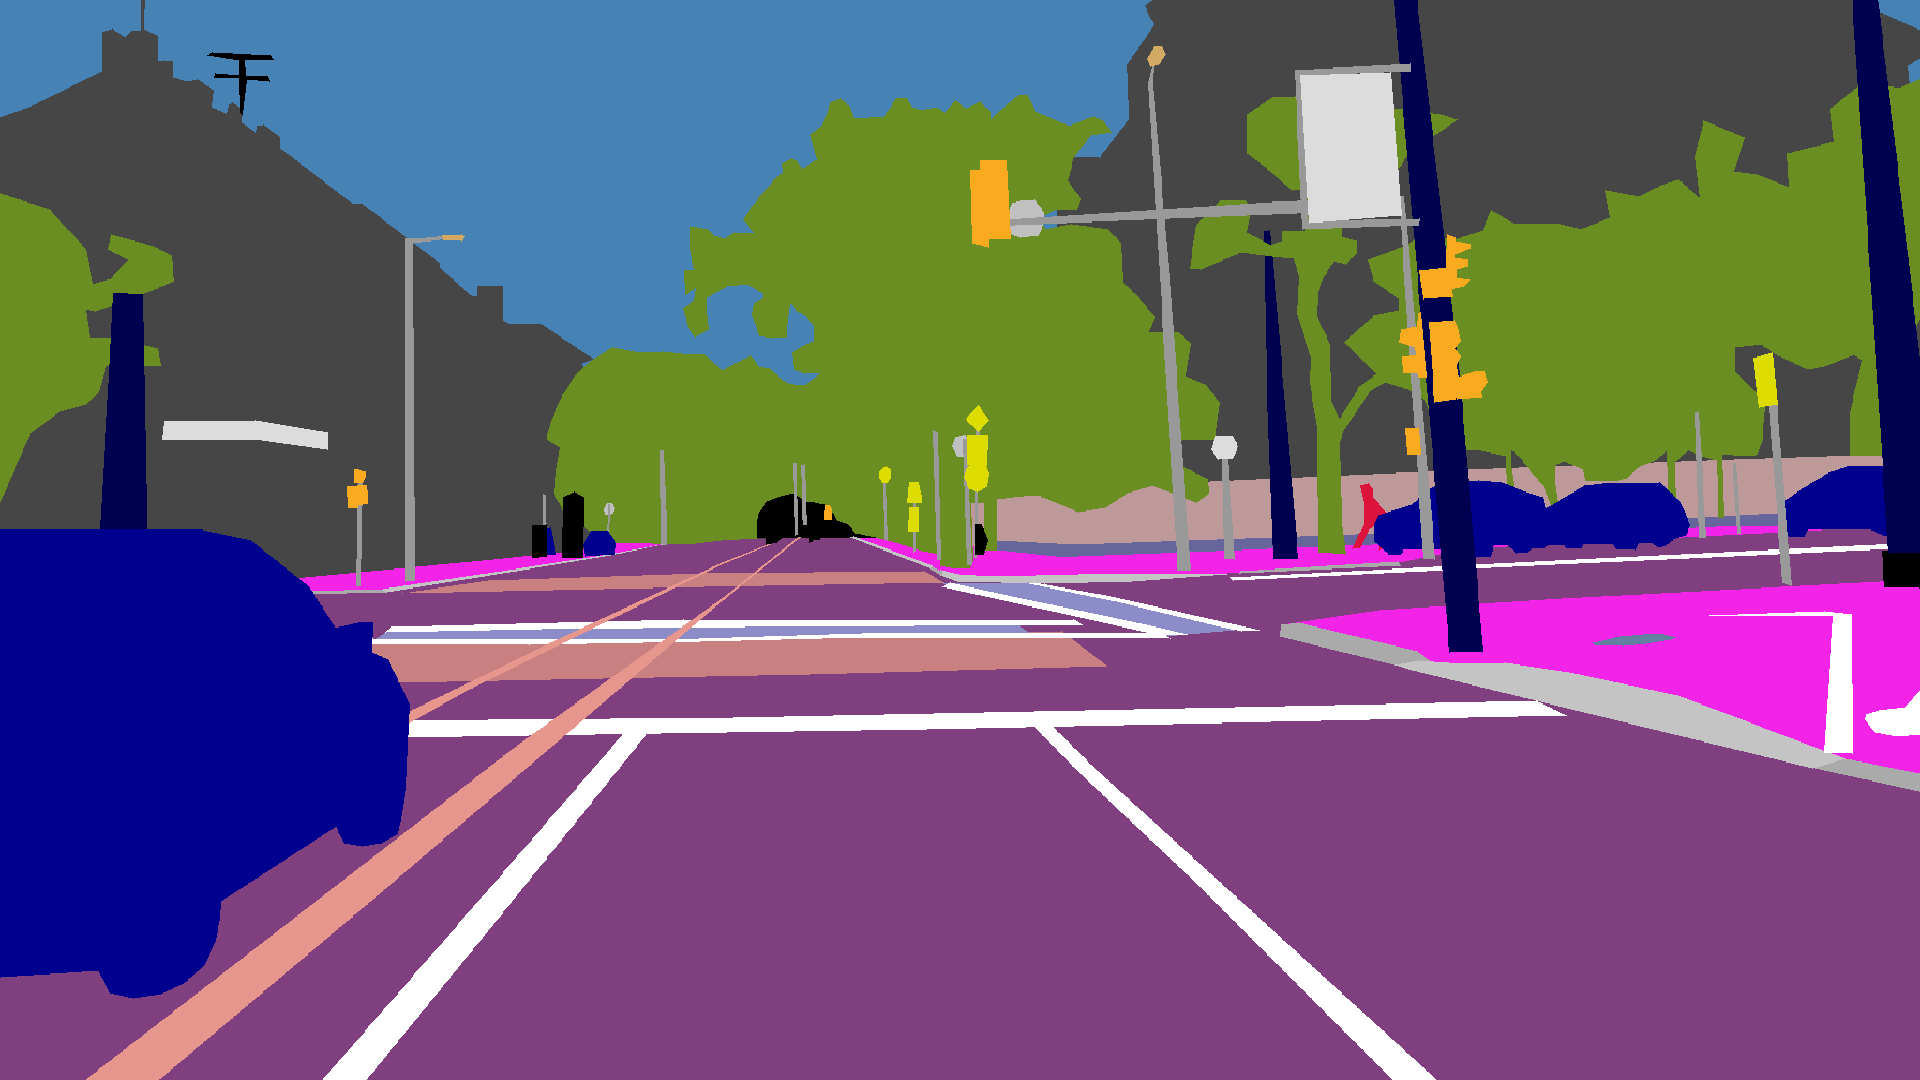

In [59]:

with open(mask_path, 'rb') as f:
    a = Image.open(f).convert('P')
a